# Labonne - Hands-On Graph Neural Networks Using Python

## Chapter 6 - Introducing graph convolutional networks

- this is a modern architecture for GNNs, most popular in literature as of 2022 - in any case, a good baseline
- it is based on trying to create a variant of CNNs for graphs
- to be more precise: it is approximation of a **graph convolution operation in graph signal processing**

Outline of chapter is:

- understand limitations of Vanilla GNN from chapter 5
- understand GCN working and why it gets better results than Vanilla GNN
- apply to Cora and Facebook datasets from chapter 5
- final application: **node regression** (says not a very common task for GNNs but useful if you work with tabular data/can convert your tabular dataset to a graph) - we will use it to predict web traffic

---

## Designing the graph convolutional layer

There's a problem we didn't talk about in chapter 5: **nodes do not all have the same number of neighbors**

- If we look at our ch05 GNN layer we didn't take this into account

Here is how we calculated the embedding of a node `i`:

`h_i = sum over j : the neighbor nodes of i of { x_j . W-transpose }`

If one node has 10000 neighbors and another has only 1, then the embedding for the former will have much larger values than that of the latter.

This is a problem for comparing embeddings : hard to compare them if the values are so different.

**Simple solution: divide each embedding by number of neighbors**

- for a single embedding vector, this is then: `h_i = (1 / degree(i)) * sum over j : the neighbor nodes of i of { x_j . W-transpose }` where we have just divided by the degree of the node `i`

But how to do this for the matrix multiplication (i.e. getting the `H` we got previously, all of the embeddings at once)

We had, for a vanilla GNN layer: `H = A_tilde-Transpose . X . W-transpose` (**TODO: check typo, is it really transpose of A_tilde???**)

We now just include the **inverse of the degree matrix, D** (where `D` is the matrix which has deg(i) on the diagonal for each of the nodes, so 1/D looks like e.g. diag( 1/3, 1/1, 1/2, 1/2) )



In [1]:
import numpy as np

In [2]:
# degree matrix for graph with 4 nodes:

D = np.array([
    [3, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 2, 0],
    [0, 0, 0, 2]
])

In [3]:
# inverse of this matrix gives us the normalization coefficients we want

np.linalg.inv(D)

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

Again, as before with `A_tilde` we added self-loops to the graph so we should also add `I` identity matrix to `D` also to get `D_tilde`

In [4]:
np.linalg.inv(D + np.identity(4)) # add diag(1,1,1,1) to the original degree matrix, D

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

## p88 book - TODO: reread

Here there is a discussion on whether you now use `D_tilde-inverse` **before or after the `A_tilde`**

He shows the 2 results - it changes just whether you end up with you normalizing every **row** of features, or every **column** of features (i.e. whether rows resp. cols sum to 1)

It says from the original paper they found that a mix of both hybrid normalization works best (**but I don't understand the explanation/reasoning given, TODO: read this elsewhere)

So you are doing a mixture of "pre and post-multiply" of `A_tilde-tranpose` by the inverse **SQUARE ROOT** of the degree matrix:

`H = D_tilde ^ -1/2  . A_tilde-tranpose  . D_tilde ^ -1/2  . X . W-transpose`

In terms of single embeddings, this works out as normalizing as:

`h_i = sum over j : neighbors of i {  (1 / sqrt(degree_i)) * (1 / sqrt(degree_j)) * x_j . W-transpose }`

in case you see these kind of expressions with 2 square roots that seem unclear where they come from etc.

## Comparing Graph Convolutional layers and Graph Linear layers

- main difference of GCN to GNN is that it **considers the node degree to weigh the features**
- let's inspect the stats of the node degrees in our datasets
- (why?: because if every node has similar number of neighbors we don't expect that the normalization term from the GCN will change compared to the GNN implementation - in trivial case where all nodes have e.g. 3 neighbors then 1/sqrt(3) * 1/sqrt(3) = 1 / 3 which is same as the dumb normalisation) 




In [6]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00a 0:00:01


In [7]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree # USED TO GET DEGREE / NUMBER OF NEIGHBORS OF A NODE
from collections import Counter
import matplotlib.pyplot as plt

In [8]:
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

Processing...
Done!


In [9]:
# number of nodes of each node in the graph
degrees = degree(data.edge_index[0]).numpy()

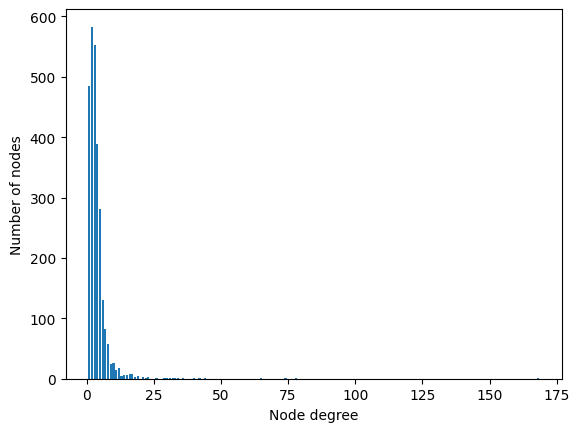

In [11]:
# to get visualization, perform a Counter of the degrees list and plot bar chart

numbers = Counter(degrees) # number of nodes of each degree

fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

plt.show()

This is the kind of node distribution where the normalization steps will be noticeable

(he does same on Facebook dataset and appearance is even more skewed so should work even better)

---

**We use PyTorch Geometric inbuilt GCN layer** - we implement it on Cora dataset now:

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv # THIS IS THE GCN layer

In [13]:
# accuracy score computation
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

**UPDATE: below, stumble across `edge_index` again without any context - reminder: it's the PAIRING of (node1, node2) that encodes all edges in the graph**

In [14]:
# -- MAIN CLASS --
# has 2 GCN layers

class GCN(torch.nn.Module):
    
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
    
    # he says forward is the same (as the GNN i presume??? review GNN to clarify the edge_index role below)
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index) # IM NOT CLEAR TODO: HOW DOES GCNConv WORK!?!? SINCE edge_index is not same as dim_h ????
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                    lr=0.01,
                                    weight_decay=5e-4,
                                    )
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index) # TODO: REVIEW THIS, what is what it's quite unclear with the shapes
            loss = criterion(out[data.train_mask],
                             data.y[data.train_mask])
            
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss:{loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss:{val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc
    

In [15]:
# train for 100 epochs
# NOTE! dataset CURRENTLY IS Cora DATASET
# ----

gcn = GCN(dataset.num_features, 16, dataset.num_classes)

print(gcn)

gcn.fit(data, epochs=100)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss:1.940 | Train Acc: 17.86% | Val Loss:1.95 | Val Acc: 9.40%
Epoch  20 | Train Loss:0.101 | Train Acc: 100.00% | Val Loss:0.80 | Val Acc: 76.60%
Epoch  40 | Train Loss:0.015 | Train Acc: 100.00% | Val Loss:0.79 | Val Acc: 77.40%
Epoch  60 | Train Loss:0.015 | Train Acc: 100.00% | Val Loss:0.77 | Val Acc: 78.00%
Epoch  80 | Train Loss:0.017 | Train Acc: 100.00% | Val Loss:0.75 | Val Acc: 78.40%
Epoch 100 | Train Loss:0.016 | Train Acc: 100.00% | Val Loss:0.75 | Val Acc: 77.80%


In [16]:
# evaluate on test dataset

acc = gcn.test(data)
print(f'GCN test accuracy: {acc*100:.2f}%')

GCN test accuracy: 79.70%


p95 book says: the average over 100 experiments is 80.1%. Also when you repeat this on Facebook dataset you get 91.5% on average.

**Compare with 74.9 and 84.8 respectively when we used basic GNN**

---

After node classificaiton we now do something a bit newer, rarer in the literature

## Predicting web traffic with node regression

- we're trying now to predict a continuous value
- we will use the `Wikipedia Network` dataset
- it is made up of 3 datasets: chamelons / crocodiles / squirrels.
- in each of the 3 datasets: nodes represent articles, edges are mutual links between articles
- node features represent the presence of particular words in the articles

**the goal is to predict the log average monthly traffic for a month, say December 2018**

- We will use the chameleon dataset (2277 nodes, 31421 edges)


In [17]:
# get data

from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

dataset = WikipediaNetwork(root=".",
                           name="chameleon",
                           transform = T.RandomNodeSplit(num_val=200, num_test=500)) # I THINK THIS IS FOR CREATING TVT SPLIT IF DATASET DOESNT ALREADY HAVE ONE
data = dataset[0]

Processing...
Done!


In [19]:
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5


**Problem with the dataset - why 5 classes?? for us we want to predict continuous value**

Turns out the 5 classes are bins of the continuous values we want to predict. Need to go elsewhere to get the data we want:

---

NOTE: FROM THIS POINT NOTEBOOK FAILED SAVE SO I LOST MY NOTES - JUST TAKING CODE FROM THIS POINT ON AS IT'S CLEAR, WILL REWRITE NOTES LATER >:(

In [37]:
import pandas as pd

df = pd.read_csv('../input/wikipedia-article-networks/chameleon/chameleon_target.csv')

In [38]:
values = np.log10(df['target'])

In [39]:
data.y = torch.tensor(values)

/tmp/ipykernel_34/2583017776.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['target'], fit=norm)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='target', ylabel='Density'>

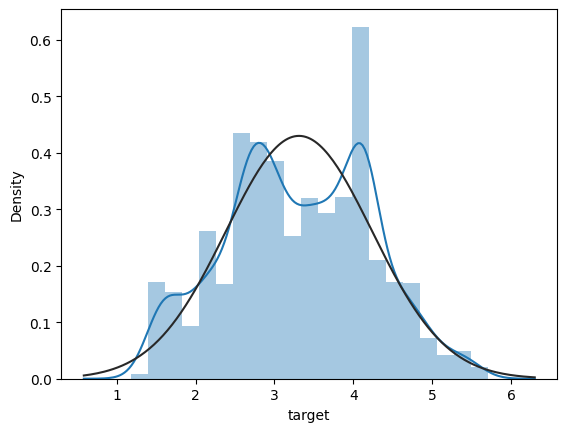

In [40]:
import seaborn as sns
from scipy.stats import norm
df['target'] = values
sns.distplot(df['target'], fit=norm)

In [41]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)
        
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h
    
    def fit(self, data, epochs):
        optimizer = torch.optim.Adam(self.parameters(),lr=0.02,weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])
                print(f"Epoch {epoch:>3} | Train Loss:{loss:.5f} | Val Loss: {val_loss:.5f}")
                
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())

In [42]:
gcn = GCN(dataset.num_features, 128, 1)
print(gcn)
gcn.fit(data, epochs=200)

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0 | Train Loss:12.10710 | Val Loss: 12.76958
Epoch  20 | Train Loss:11.86138 | Val Loss: 12.50125
Epoch  40 | Train Loss:10.09703 | Val Loss: 10.19938
Epoch  60 | Train Loss:3.26303 | Val Loss: 3.76266
Epoch  80 | Train Loss:0.75056 | Val Loss: 0.80932
Epoch 100 | Train Loss:0.59623 | Val Loss: 0.67711
Epoch 120 | Train Loss:0.47935 | Val Loss: 0.59139
Epoch 140 | Train Loss:0.45910 | Val Loss: 0.67698
Epoch 160 | Train Loss:0.42312 | Val Loss: 0.57479
Epoch 180 | Train Loss:0.34479 | Val Loss: 0.60370
Epoch 200 | Train Loss:0.32801 | Val Loss: 0.54766


In [43]:
loss = gcn.test(data)
print(f'GCN test loss: {loss:.5f}')

GCN test loss: 0.84815


In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE= {mae:.4f}')
print('=' * 43)

MSE = 0.8482 | RMSE = 0.9210 | MAE= 0.7068


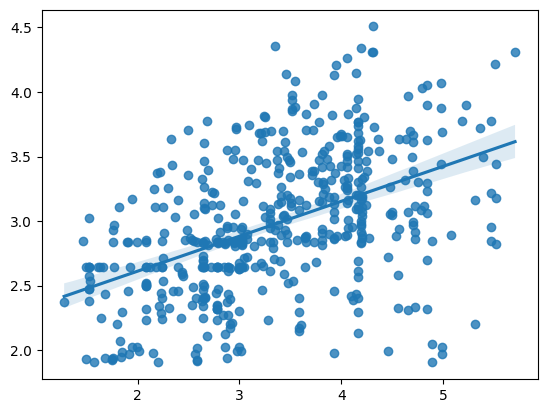

In [45]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)